In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import australia
import models
import mscthesis
import pandas as pd
import geopandas as gpd
import validation
import numpy as np
import datetime
import genericvalidation
import matplotlib.pyplot as plt

In [3]:
sampler = models.Sampler(
    model=models.PreferentialReturn(
        p=0.2,
        gamma=0.8,
        region_sampling=models.RegionTransitionZipf(
            beta=0.05,
        ),
        jump_size_sampling=models.JumpSizeTrueProb(),
    ),
    daily_trips_sampling=models.NormalDistribution(3.14, 1.8),
    n_days=7*20,
    geotweets_path="",
)

In [4]:
geotweets = mscthesis.read_geotweets_raw("../../dbs/australia/geotweets.csv").set_index('userid')

# Only look at weekday trips
geotweets = geotweets[(geotweets['weekday'] < 6) & (0 < geotweets['weekday'])]

# Remove users who don't have home visit in geotweets
home_visits = geotweets.query("label == 'home'").groupby('userid').size()
geotweets = geotweets.loc[home_visits.index]

# Remove users with less than 20 tweets
tweetcount = geotweets.groupby('userid').size()
geotweets = geotweets.drop(labels=tweetcount[tweetcount < 20].index)

# Remove users with only one region
regioncount = geotweets.groupby(['userid', 'region']).size().groupby('userid').size()
geotweets = geotweets.drop(labels=regioncount[regioncount < 2].index)

# Ensure the tweets are sorted chronologically
geotweets = geotweets.sort_values(by=['userid', 'createdat'])

In [5]:
geotweets.shape

(601369, 12)

In [6]:
baseline = models.geotweets_to_visits(geotweets)

In [332]:
geotweetsx = geotweets.loc[geotweets.groupby('userid').size()[:10].index]

In [ ]:
print(datetime.datetime.now())
visits = sampler.sample(geotweets)
print(datetime.datetime.now())

In [10]:
visits

,day,timeslot,kind,latitude,longitude,region
userid,,,,,,
36303,0,0,region,-33.748644,151.045860,121
36303,0,1,region,-33.698014,151.029889,111
36303,1,0,region,-33.748644,151.045860,121
36303,1,1,region,-33.750319,151.046052,135
36303,2,0,region,-33.748644,151.045860,121
...,...,...,...,...,...,...
790766431428194304,138,4,region,-33.888820,151.240760,1
790766431428194304,139,0,region,-33.888820,151.240760,1
790766431428194304,139,1,region,-33.892130,151.250500,10


In [8]:
visits.to_csv('./../../dbs/australia/visits.csv')

In [9]:
zones = australia.validation_zones()
hts = australia.validation_travel_survey()

In [11]:
home_locations = pd.read_csv('../../dbs/australia/homelocations.csv')
home_locations = gpd.GeoDataFrame(
    home_locations,
    crs="EPSG:4326",
    geometry=gpd.points_from_xy(home_locations.longitude, home_locations.latitude),
).to_crs(zones.crs)

In [12]:
zone_to_user = gpd.sjoin(home_locations, zones)[['zone', 'userid']]

In [13]:
def prepare_travel_survey(hts):
    hts = hts[['WAVE', 'zone', 'WEIGHTED_TRIPS', 'WEIGHTED_TOTAL_DISTANCE']].groupby(['WAVE', 'zone']).sum()
    hts = hts.WEIGHTED_TOTAL_DISTANCE / hts.WEIGHTED_TRIPS 
    hts = hts.loc['2018/19']
    return hts


def visits_to_trips(visits):
    def trip_dist(t):
        return mscthesis.haversine_distance(
            t.latitude_origin, t.longitude_origin, 
            t.latitude_destination, t.longitude_destination,
        )
    print("converting to trips")
    trips = mscthesis.visit_gaps(visits)
    print("calculating distances")
    trip_dists = trips.apply(trip_dist, axis=1)
    return trip_dists

def summarize_trips_per_zone(trips, user_zone):
    trip_summaries = pd.DataFrame.from_dict(dict(
        num_trips = trips.groupby('userid').size(),
        total_distance = trips.groupby('userid').sum(),
    ))
    zone_trips = user_zone.merge(trip_summaries, on='userid')
    zone_trips = zone_trips.groupby('zone').sum()
    zone_avg_distance = zone_trips.total_distance / zone_trips.num_trips
    return zone_avg_distance
    

In [14]:
groundtruth_avg_distance = prepare_travel_survey(hts)

In [15]:
model_trips = visits_to_trips(visits)
model_avg_distance = summarize_trips_per_zone(model_trips, zone_to_user)
model_avg_distance = model_avg_distance.reindex(groundtruth_avg_distance.index, fill_value=0)

converting to trips
calculating distances


In [16]:
baseline_trips = visits_to_trips(baseline)
baseline_avg_distance = summarize_trips_per_zone(baseline_trips, zone_to_user)
baseline_avg_distance = baseline_avg_distance.reindex(groundtruth_avg_distance.index, fill_value=0)

converting to trips
calculating distances


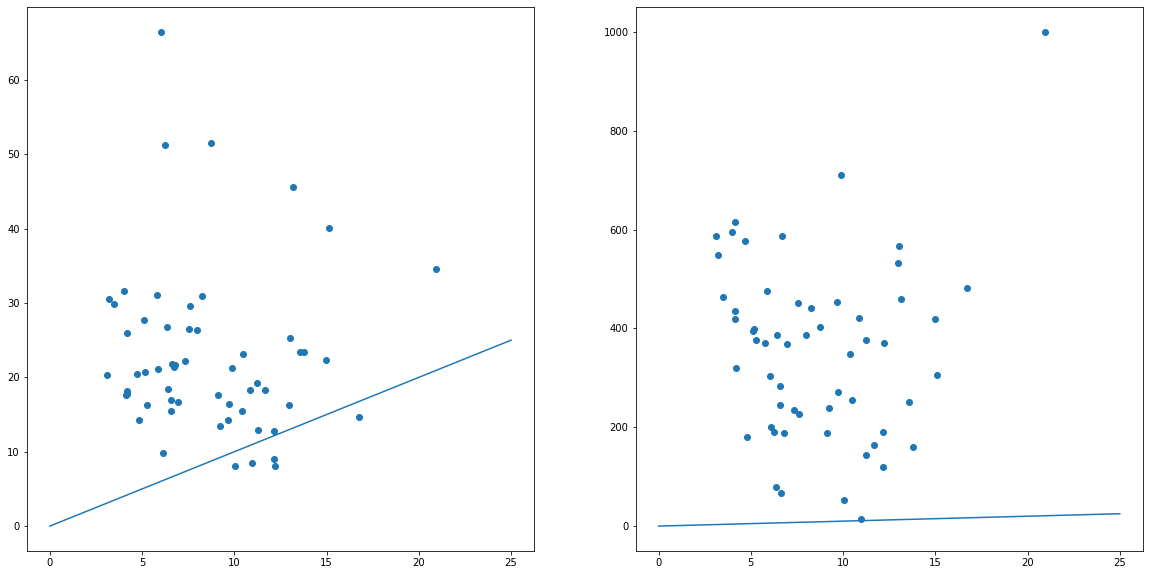

In [17]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

axes[0].scatter(x=groundtruth_avg_distance, y=model_avg_distance)
axes[0].plot([0, 25], [0,25])
axes[1].scatter(x=groundtruth_avg_distance, y=baseline_avg_distance)
axes[1].plot([0, 25], [0,25])

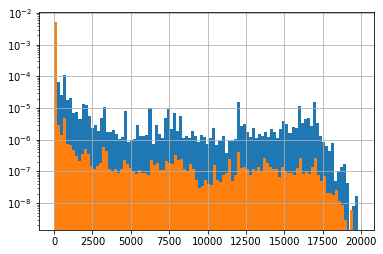

In [18]:
ax = baseline_trips.hist(log=True, bins=100, density=True)
model_trips.hist(ax=ax,log=True, bins=100, density=True)